# Individual Project Report

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source('cleanup.R')

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


## (1) Data Description:
We have decided that the players dataset is the only one relevant to answering our group's specific question. The players dataset is a dataframe with 195 observations and 9 variables:
* `experience`(character) - the self-reported Minecraft experience level of the player, including amateur, beginner, regular, pro, and veteran
* `subscribe` (logical) - whether or not the individual chose to subscribe to the e-mailing list of the study
* `hashedEmail` (character) - the encrypted email hash associated with the individual
* `played_hours` (douple precision) - the amount of hours the individual played on the study's Minecraft server
* `name` (character) - the randomised anonymous name chosen by the individual
* `gender` (character) - the self-reported gender identity of the individual
* `age` (double precision) - the self-reporeted age of the individual 
* `individualId` (logical) - used to identify individuals of interest, though the entire column only contains observations with "NA"
* `organizationName` (logical) - used to identify organizations of interest, though the entire column only contains observations with "NA"

There are some general problems with the data pertaining to sample size/population as well as the subjectivity of the self-reported variables. Firstly, due to being a UBC-led survey, it is likely that most of those who signed up for the survery are busy university students. This may be associated with the large amount of observations where an individual would sign up, but then contribute close to 0 hours of playtime. As such, if we were to only look at those who contributed very large amounts of playtime in comparison (100+ hours), our sample size becomes very small with less than a dozen observations. Hence, it is difficult to create a model describing the characteristics of these kinds of players. We will need to decide strategically what data is relevent when trying to answer our question.

Furthermore, the criteria for certain self-reported variables are quite subjective. For example, the questionnaire asks players to self-report their experience level. They describe the "veteran" level as those who have played the game since its release in 2015. As such, those who have casually played the game since then but not consistently could be classified as veterans. As such, it is best to go into the data analysis understanding that if we predict a certain demographic to be associated with higher playtimes, we are actually describing those who self-describe themselves as such in place of a quantative metric. 

## (2) Question:
Using KNN classfification, we want to see if we can predict a player's self-reported experience level from their playing time and age. We are hoping that this will allows us to answer question 1 that the study's researchers are asking. For example, let's say our ideal hypothetical study participant is a 20-year old university student who contributes at least 1 hour of playtime, because their demographic would be easily accessible to the university researchers. Given these variables, we can try to use our pre-existing data to see what kind of experience level player this would be, and focus our data collection towards them. 

We may need to play around a bit and filter the ranges of our variables that we use to train our model depending on what the trends in playtime from the original data tell us. 

## (3) Exploratory Data Analysis and Visualization
Let's first read in the raw players data and look for any wrangling we need to do so that our classificatiion is smooth.

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17,NA,NA
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17,NA,NA
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,91,NA,NA


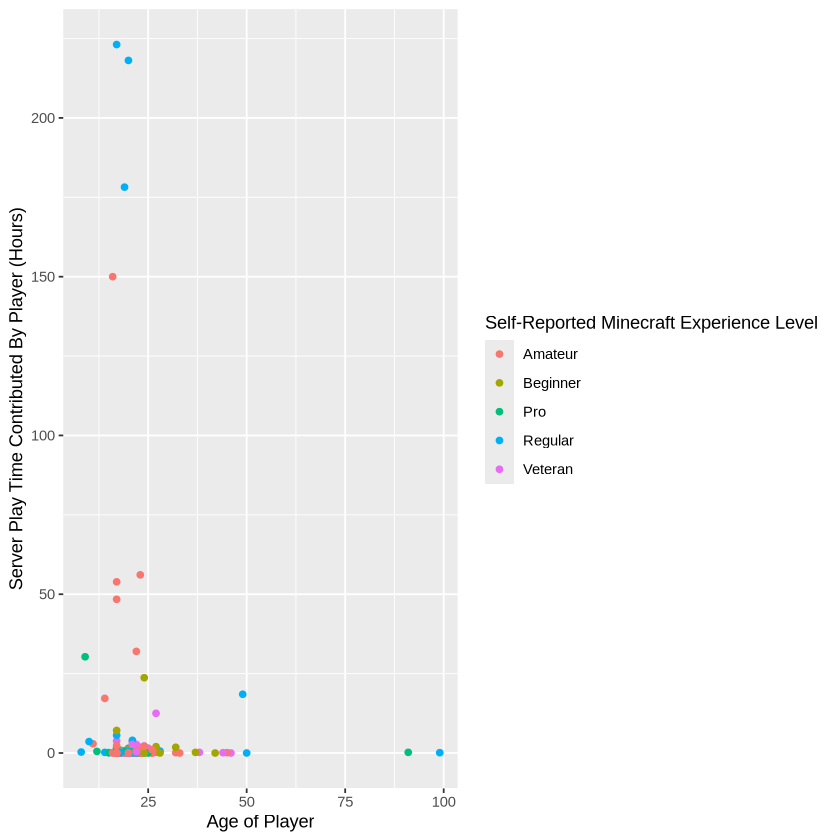

In [9]:
#reading in the raw, unprocessed data
raw_data <- read_csv("players.csv")
raw_data

#initial plot of the three variables of interest, play time, age, & experience level
raw_plot <- raw_data |> ggplot(aes(x = age, y = played_hours)) +
        geom_point(aes(color = experience)) +
        labs(x = "Age of Player", y = "Server Play Time Contributed By Player (Hours)", color = "Self-Reported Minecraft Experience Level")
raw_plot

Firstly, we can see that the data can be successfully read into R. However, when we plot the raw data, we notice that there are far more observations for players under age 50 and those with 50 hours of play time or less. Namely, there are many players who contributed close to zero hours to the server, cluttering that part of the graph. Assuming that the ideal demographic for the researchers would be those who are university to prime working age due to ease of sampling, we decided to filter the data to consider only those who are 50 years old or younger. Furthermore, since we are interested in players who would contribute a lot of play time to the server, we should only consider those who have played 1 or more hours. 

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


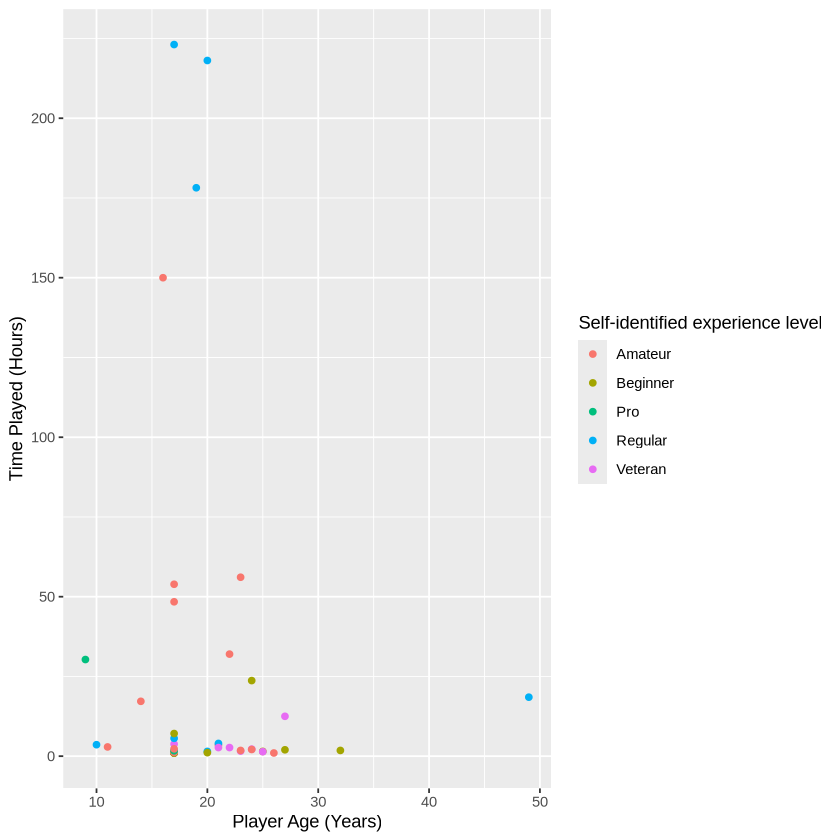

In [11]:
# filtering the data to consider only players of interest
players_data <- read_csv("players.csv") |> 
            select(experience, played_hours, age) |>
            filter(played_hours >= 1, age <= 50)

# plotting the new filtered data
players_plot <- players_data |> 
            ggplot(aes(x = age, y = played_hours)) + 
            geom_point(aes(color = experience)) + 
            labs(x = "Player Age (Years)", y = "Time Played (Hours)", colour = "Self-identified experience level")
players_plot

After filtering the data, we can now visualize the points much clearer without the cutter of the unnecessary points. However, we do see that there is not much data for played_hours between around 50 and 150 hours, demonstrating the aforementioned problems with a smaller sample size. Furthermore, there are not that many clear clusters of experiences levels. However, there are two slight clusters of "regular" and "amateur." We will need to optimize the k value and test the reliability of this model going forward.

## (4) Methods and Plan
As aforementioned, we plan to use KNN classification to predict the self-reported experience level of a player based on their age and play time. This will inform us about the demographic of players that are likely to contribute a certain amount of hours. We can plot how our model will classify players and see what classification occurs at areas where players contribute large amounts of playtime. We thought that it would be helpful to use classification to address this question as we could gain categorical insight on the demographic of players (e.g. those who are a certain age range and report themself at a certain experience level) that are likely to contribute larger amounts of playtimes. We thought this would be a more nuanced and interesting way of addressing the question rather than simply trying to establish a regression relationship between age and play time, for example. 

In doing this, we are assuming that the self-reported experience levels are more indicative of how those players identify themsleves rather than by hard quantitative definitions or labels (e.g. those who identify as veterans or pros of Minecraft aren't necessarily consistently playing the game). Furthermore, we are making the assumption that the study's researchers are looking to target sample sizes that are easily accessible to them in a university or professional setting. As such, we have decided to disregard players above the age of 50. We are also assuming that we are not interested in any players that have contributed less than an hour of playtime. Applying these filters unfortunatey does decrease the amount of observations we have to work with. Hence, one limitation of our model is that we are working with a small sample size and thus may make some incorrect classifications as a result. For example, after we apply our filters to the data, only one player who self-reports as a pro remains. This means that the KNN model will never classify any players as a "pro" experience level. However, the model may still have some merit if it can still accurate classify all of our other points. This will need to be validated and tested.

When we model the data, we will split it into 70% training data and 30% testing data to validate our KNN classification model. We will do this after we have wrangled and pre-processed our data and before we specify anything for our model. We will use the training data to establish an optimal value of k and then use the testing data to cross-validate it. 